# Visualizing training behavior

In [1]:
using JLD2, LinearAlgebra, Makie, CairoMakie

include("../../MyTwoLayerNN/MyTwoLayerNN.jl")
include("../experimentplots.jl")

using .MyTwoLayerNN

Create the NN

In [50]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

# NN parameters
m = 1_000
γ = 1.5    # w-lag (1.5, 0.25) lr=10, a-lag (1.5, -0.5) lr=1000
γ′ = -0.5

nn = TwoLayerNN(d, m, γ, γ′)

# Create copy of inital weights 
initialNN = MyTwoLayerNN.copy(nn)

# Training parameters
learning_rate = 1000.0
max_steps = 100_000_000

training_data = TrainingData(dataX, dataY, learning_rate, max_steps)

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 1000.0, 100000000)

Create callback function

In [51]:
w_norms::Vector{Float64} = []
a_norms::Vector{Float64} = []

function mycallback(nn, step, loss)
    if step % 1000 == 1
        push!(w_norms, norm(nn.w))
        push!(a_norms, norm(nn.a))
    end
end

mycallback (generic function with 1 method)

Train the network

In [52]:
train!(nn, training_data; callback=mycallback)

Number of steps: 653133


Visualize size of w and a parameters during training

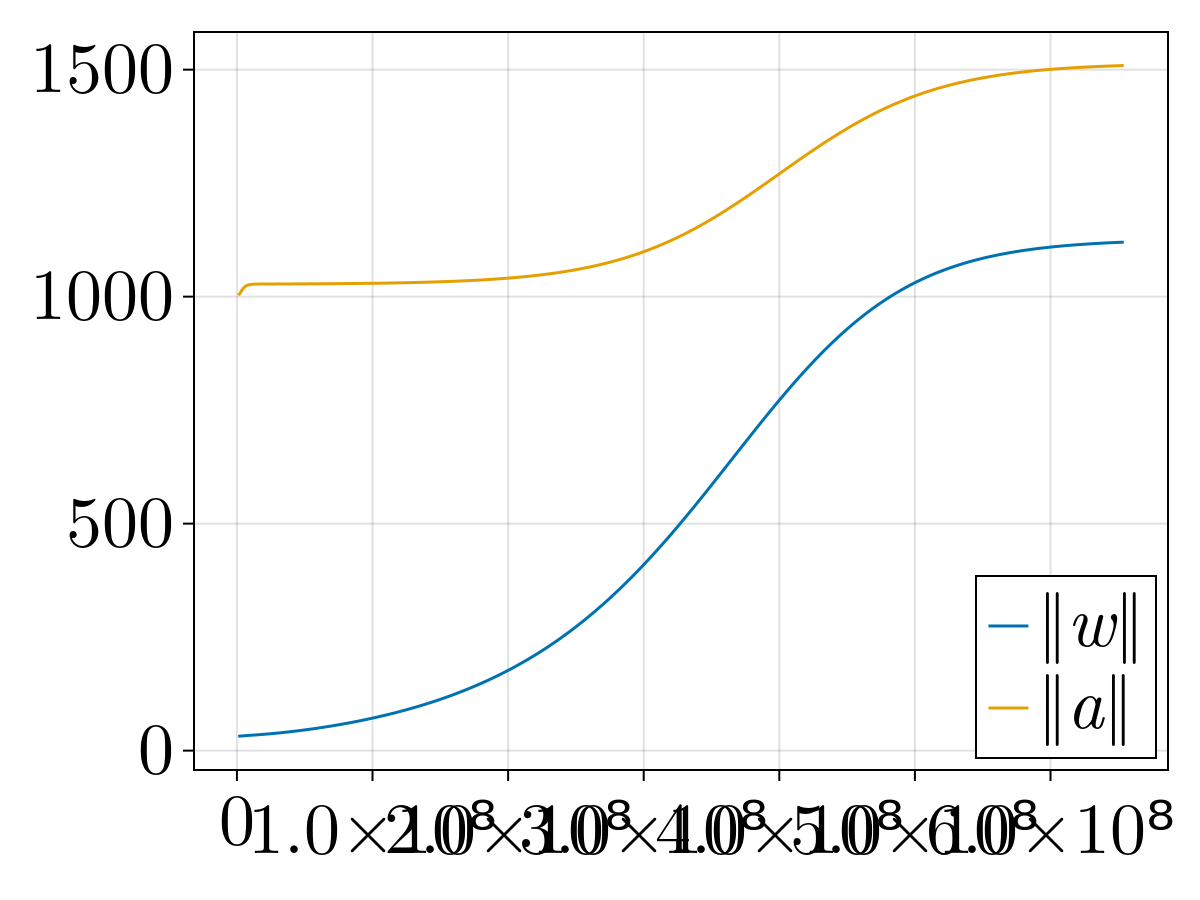

In [53]:
f = Figure()
ax = Axis(f[1, 1])

steps = 1000 * (1:length(w_norms)) * learning_rate

w_lines = lines!(ax, steps, w_norms)
a_lines = lines!(ax, steps, a_norms)

axislegend(ax, [w_lines, a_lines], [L"\Vert w\Vert", L"\Vert a\Vert"], position=:rb)

f

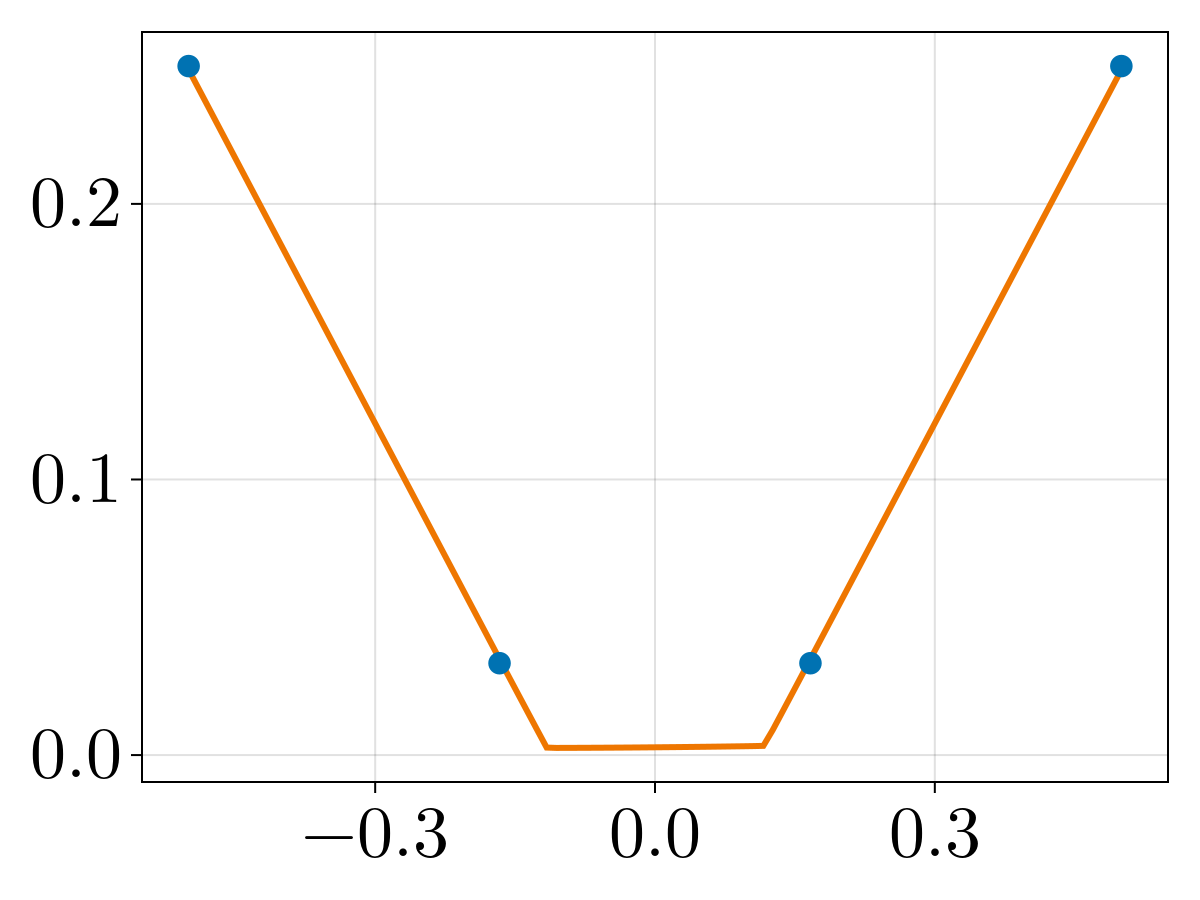

In [54]:
f = Figure()
ax = Axis(f[1, 1])

createlineplot!(ax, nn, training_data)

f

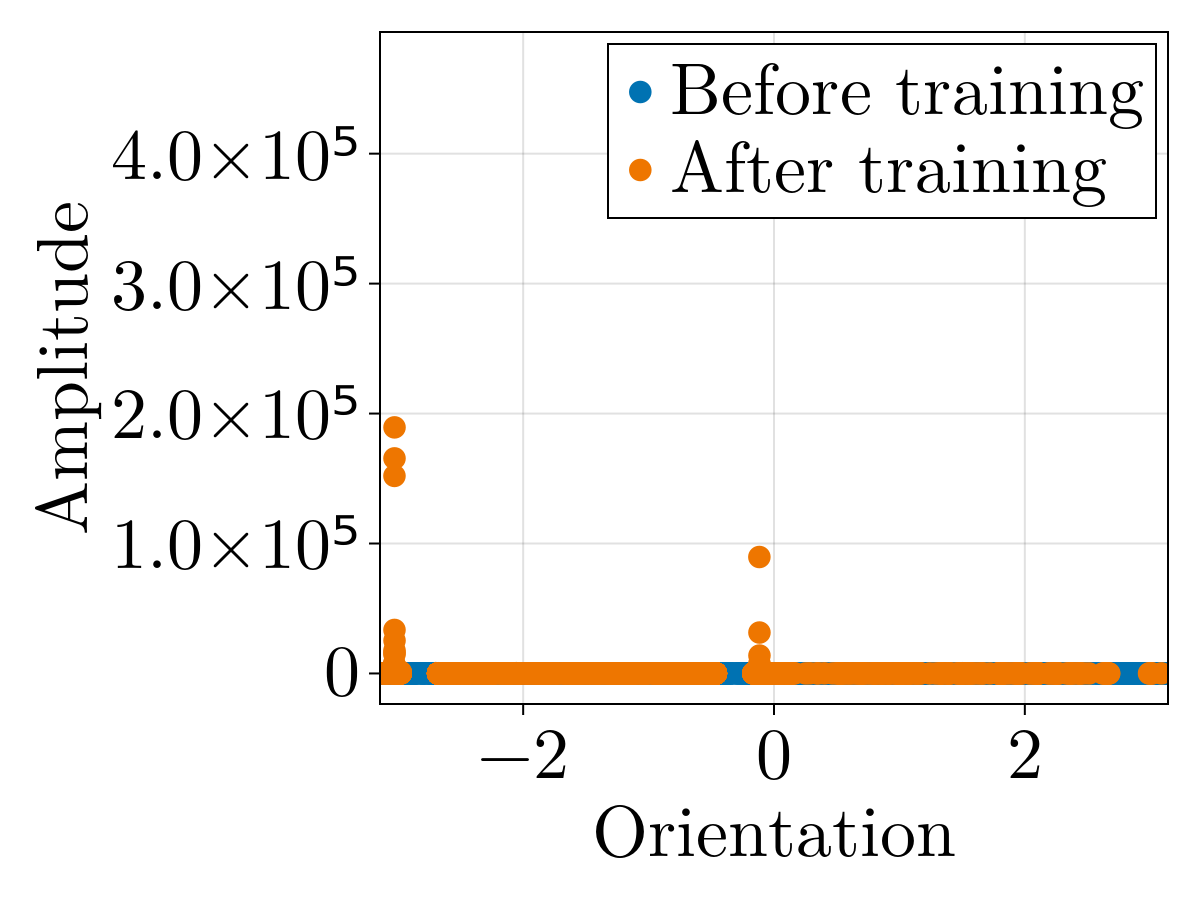

In [55]:
f = Figure()
ax = Axis(f[1, 1])

createorientiationplot!(ax, initialNN, nn)

f